In [1]:
import numpy as np
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pylab as plt
from pathlib import Path

In [3]:
model_name_it = "Efficient_net_B0_it.h5"

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

In [6]:
monitor_it = tf.keras.callbacks.ModelCheckpoint(model_name_it, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=False,\
                                             mode='min')

In [7]:
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!= 0:
        lr = lr/2
    return lr

In [8]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [9]:
gen_params = {"featurewise_center":False,\
              "featurewise_std_normalization":False,}

Train and validation generators

In [10]:
generator = ImageDataGenerator(**gen_params, validation_split=0.4,  preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

In [11]:
bs = 16 # batch size

In [24]:
path = Path("D:/Mestrado/ENEL645/Assigment_3/cards_dataset/whole_dataset/term-project/dataset")

In [25]:
img_height = 320
img_width = 320

In [26]:
classes_names = ["2_clubs","2_diamonds","2_hearts","2_spades",\
               "3_clubs","3_diamonds","3_hearts","3_spades",\
               "4_clubs","4_diamonds","4_hearts","4_spades",\
               "5_clubs","5_diamonds","5_hearts","5_spades",\
               "6_clubs","6_diamonds","6_hearts","6_spades",\
               "7_clubs","7_diamonds","7_hearts","7_spades",\
               "8_clubs","8_diamonds","8_hearts","8_spades",\
               "9_clubs","9_diamonds","9_hearts","9_spades",\
               "10_clubs","10_diamonds","10_hearts","10_spades",\
               "ace_clubs","ace_diamonds","ace_hearts","ace_spades",\
               "jack_clubs","jack_diamonds","jack_hearts","jack_spades",\
               "joker,"
               "king_clubs","king_diamonds","king_hearts","king_spades",\
               "queen_clubs","queen_diamonds","queen_hearts","queen_spades"]
              

In [27]:
train_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='training',
    interpolation="nearest",
    classes = classes_names) # set as training data

Found 1087 images belonging to 52 classes.


In [28]:
validation_generator = generator.flow_from_directory(
    directory = path,
    target_size=(img_height, img_width),
    batch_size=bs,
    class_mode="categorical",
    subset='validation',
    interpolation="nearest",
    classes = classes_names) # set as validation data

Found 687 images belonging to 52 classes.


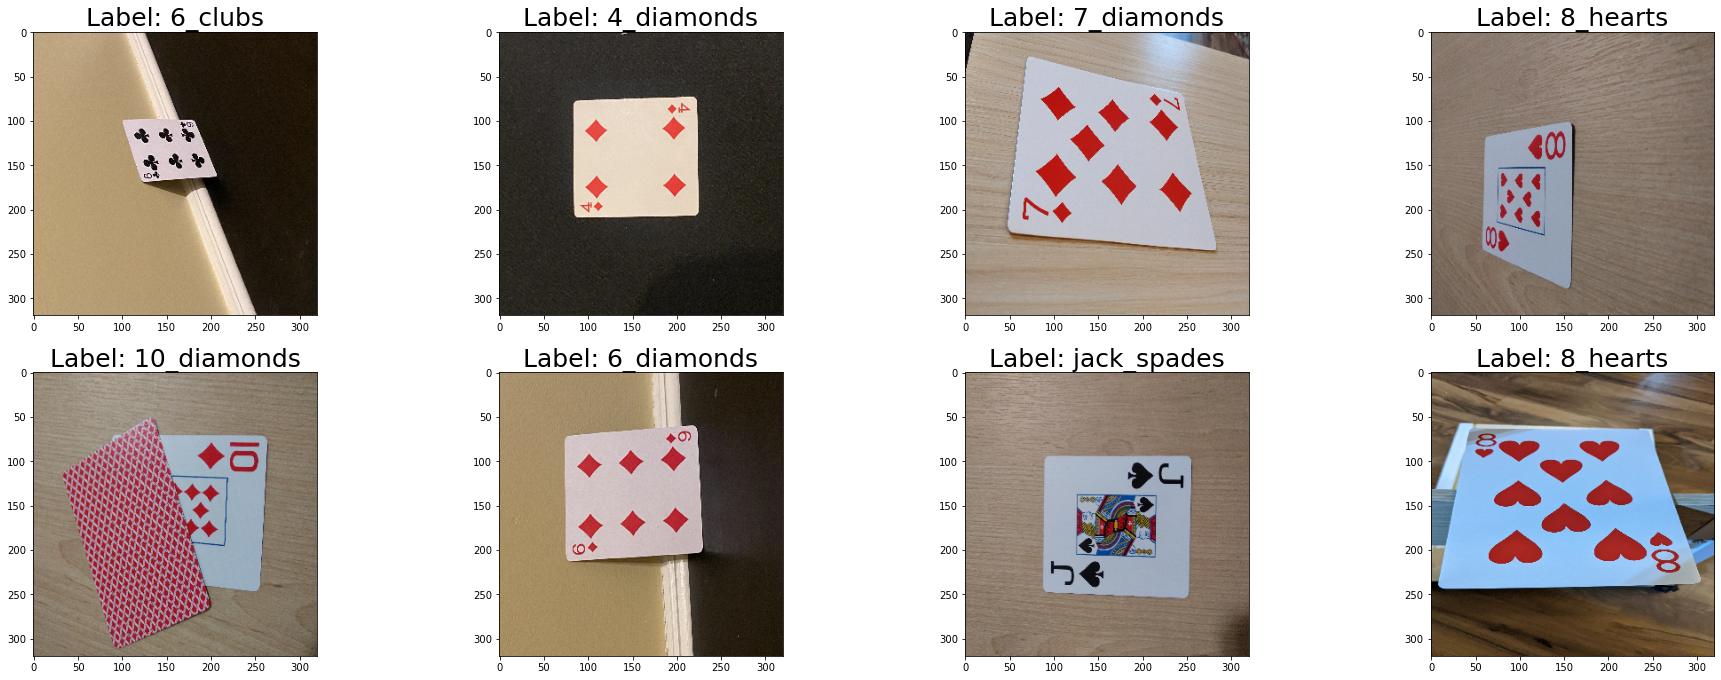

In [29]:
plt.figure(figsize = (32,24))
Xbatch,Ybatch = validation_generator.__getitem__(0)
for ii in range(int(bs/2)):
    plt.subplot(4,4,ii+1)
    plt.imshow((Xbatch[ii]- Xbatch[ii].min())/(Xbatch.max() - Xbatch[ii].min()), cmap = "gray")
    class_idx = int(Ybatch[ii].argmax())
    plt.title("Label: {}".format(classes_names[class_idx]), fontsize=25)
plt.show()

In [ ]:
Defining the model

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet', 
    input_shape=(img_height, img_width, 3),
    include_top=False)

In [19]:
base_model.trainable = False

In [20]:
x1 = base_model(base_model.input, training = True)
x2 = tf.keras.layers.Flatten()(x1)
out = tf.keras.layers.Dense(len(classes_names),activation = 'softmax')(x2)
model = tf.keras.Model(inputs = base_model.input, outputs =out)

In [21]:
print("Initial Training Model")
print(model.summary())

Initial Training Model
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 10, 10, 1280)     4049571   
                                                                 
 flatten (Flatten)           (None, 128000)            0         
                                                                 
 dense (Dense)               (None, 52)                6656052   
                                                                 
Total params: 10,705,623
Trainable params: 6,656,052
Non-trainable params: 4,049,571
_________________________________________________________________
None


In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-8),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
history_it = model.fit(train_generator, epochs=1000, verbose = 1, \
                       workers=8, validation_data = (validation_generator),  callbacks= [early_stop, monitor_it, lr_schedule])

Epoch 1/1000
85/85 [==============================] - 47s 462ms/step - loss: 4.7440 - accuracy: 0.0230 - val_loss: 4.6033 - val_accuracy: 0.0234 - lr: 1.0000e-08
Epoch 2/1000
85/85 [==============================] - 40s 436ms/step - loss: 4.7265 - accuracy: 0.0193 - val_loss: 4.5792 - val_accuracy: 0.0280 - lr: 1.0000e-08
Epoch 3/1000
75/85 [=========================>....] - ETA: 2s - loss: 4.7232 - accuracy: 0.0192

UnknownError: Graph execution error:

2 root error(s) found.
  (0) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Mestrado\\ENEL645\\Assigment_3\\cards_dataset\\whole_dataset\\term-project\\dataset\\4_spades\\kg_zqgzcwzedr.jpg'
Traceback (most recent call last):

  File "D:\Anaconda\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "D:\Anaconda\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "D:\Anaconda\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "D:\Anaconda\lib\site-packages\keras\engine\data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "D:\Anaconda\lib\site-packages\keras\utils\data_utils.py", line 785, in get
    raise e

  File "D:\Anaconda\lib\site-packages\keras\utils\data_utils.py", line 776, in get
    inputs = self.queue.get(block=True, timeout=5).get()

  File "D:\Anaconda\lib\multiprocessing\pool.py", line 771, in get
    raise self._value

  File "D:\Anaconda\lib\multiprocessing\pool.py", line 125, in worker
    result = (True, func(*args, **kwds))

  File "D:\Anaconda\lib\site-packages\keras\utils\data_utils.py", line 566, in get_index
    return _SHARED_SEQUENCES[uid][i]

  File "D:\Anaconda\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "D:\Anaconda\lib\site-packages\keras_preprocessing\image\iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "D:\Anaconda\lib\site-packages\keras_preprocessing\image\utils.py", line 113, in load_img
    with open(path, 'rb') as f:

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Mestrado\\ENEL645\\Assigment_3\\cards_dataset\\whole_dataset\\term-project\\dataset\\4_spades\\kg_zqgzcwzedr.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_2]]
  (1) UNKNOWN:  FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Mestrado\\ENEL645\\Assigment_3\\cards_dataset\\whole_dataset\\term-project\\dataset\\4_spades\\kg_zqgzcwzedr.jpg'
Traceback (most recent call last):

  File "D:\Anaconda\lib\site-packages\tensorflow\python\ops\script_ops.py", line 271, in __call__
    ret = func(*args)

  File "D:\Anaconda\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "D:\Anaconda\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py", line 1004, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "D:\Anaconda\lib\site-packages\keras\engine\data_adapter.py", line 830, in wrapped_generator
    for data in generator_fn():

  File "D:\Anaconda\lib\site-packages\keras\utils\data_utils.py", line 785, in get
    raise e

  File "D:\Anaconda\lib\site-packages\keras\utils\data_utils.py", line 776, in get
    inputs = self.queue.get(block=True, timeout=5).get()

  File "D:\Anaconda\lib\multiprocessing\pool.py", line 771, in get
    raise self._value

  File "D:\Anaconda\lib\multiprocessing\pool.py", line 125, in worker
    result = (True, func(*args, **kwds))

  File "D:\Anaconda\lib\site-packages\keras\utils\data_utils.py", line 566, in get_index
    return _SHARED_SEQUENCES[uid][i]

  File "D:\Anaconda\lib\site-packages\keras_preprocessing\image\iterator.py", line 65, in __getitem__
    return self._get_batches_of_transformed_samples(index_array)

  File "D:\Anaconda\lib\site-packages\keras_preprocessing\image\iterator.py", line 227, in _get_batches_of_transformed_samples
    img = load_img(filepaths[j],

  File "D:\Anaconda\lib\site-packages\keras_preprocessing\image\utils.py", line 113, in load_img
    with open(path, 'rb') as f:

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Mestrado\\ENEL645\\Assigment_3\\cards_dataset\\whole_dataset\\term-project\\dataset\\4_spades\\kg_zqgzcwzedr.jpg'


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_14919]